In [27]:
from importlib import reload
import utils_tf as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import IPython
import IPython.display
import matplotlib as mpl
import pandas as pd
import seaborn as sns

reload(u)

<module 'utils_tf' from 'c:\\Users\\Max\\OneDrive - National University of Singapore\\CentraleSupelec\\Networks for intelligent cities\\Project\\ST7_Forecasting_RTE\\utils_tf.py'>

Model here uses 50 data points to predict 1 data point into the future

In [6]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [7]:
wide_RNN_window = u.WindowGenerator(
    input_width=50, label_width=50, shift=1,
    label_columns=['y'])

In [8]:
history = u.compile_and_fit(lstm_model, wide_RNN_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_RNN_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_RNN_window.test, verbose=0)

Epoch 1/20
1917/1917 [==============================] - 45s 22ms/step - loss: 0.0435 - root_mean_squared_error: 0.2085 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 2/20
1917/1917 [==============================] - 40s 21ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 3/20
1917/1917 [==============================] - 53s 28ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 4/20
1917/1917 [==============================] - 48s 25ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 5/20
1917/1917 [==============================] - 51s 27ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 6/20
1917/1917 [==============================] - 43s 22ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 -

In [9]:
#Saving model as h5 file so it can be loaded at anytime
lstm_model.save("lstm_model_single_step.h5")

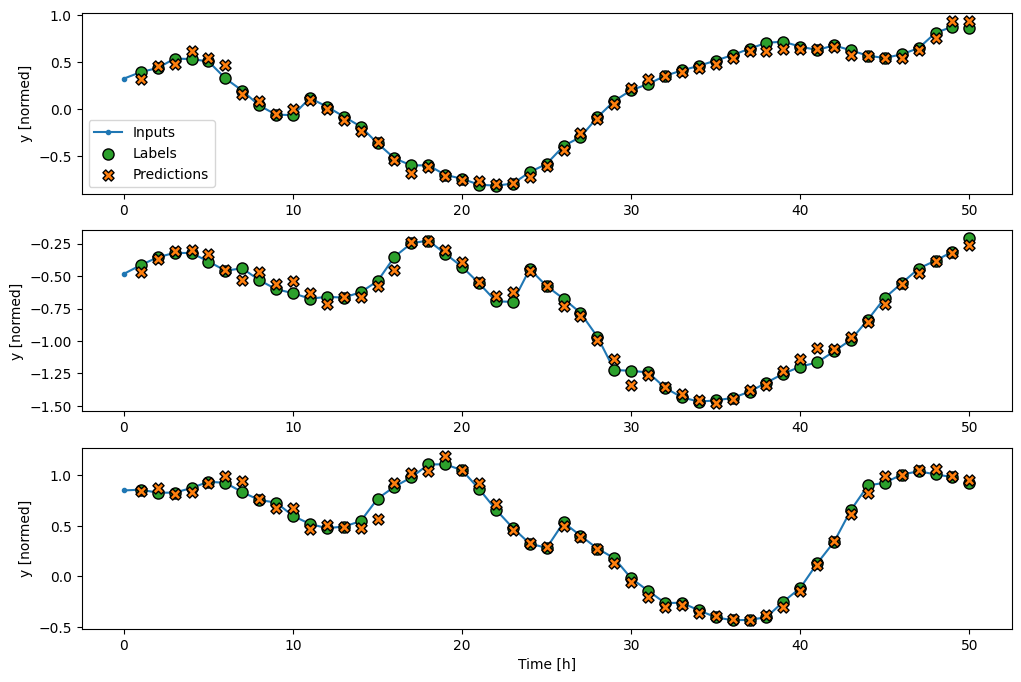

In [10]:
wide_RNN_window.plot(lstm_model)

Model here uses 50 data points (25 hours) to predict 50 datapoints into the future in one-shot

In [28]:
OUT_STEPS = 50
num_features = 1
multi_window = u.WindowGenerator(input_width=50,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

Epoch 1/20
1916/1916 [==============================] - 45s 22ms/step - loss: 0.1712 - root_mean_squared_error: 0.4137 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2806
Epoch 2/20
1916/1916 [==============================] - 41s 21ms/step - loss: 0.0783 - root_mean_squared_error: 0.2797 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2679
Epoch 3/20
1916/1916 [==============================] - 40s 21ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_loss: 0.0765 - val_root_mean_squared_error: 0.2766
Epoch 4/20
1916/1916 [==============================] - 39s 20ms/step - loss: 0.0637 - root_mean_squared_error: 0.2524 - val_loss: 0.0689 - val_root_mean_squared_error: 0.2625
Epoch 5/20
1916/1916 [==============================] - 41s 21ms/step - loss: 0.0599 - root_mean_squared_error: 0.2447 - val_loss: 0.0653 - val_root_mean_squared_error: 0.2556
Epoch 6/20
1916/1916 [==============================] - 37s 19ms/step - loss: 0.0569 - root_mean_squared_error: 0.2386 -

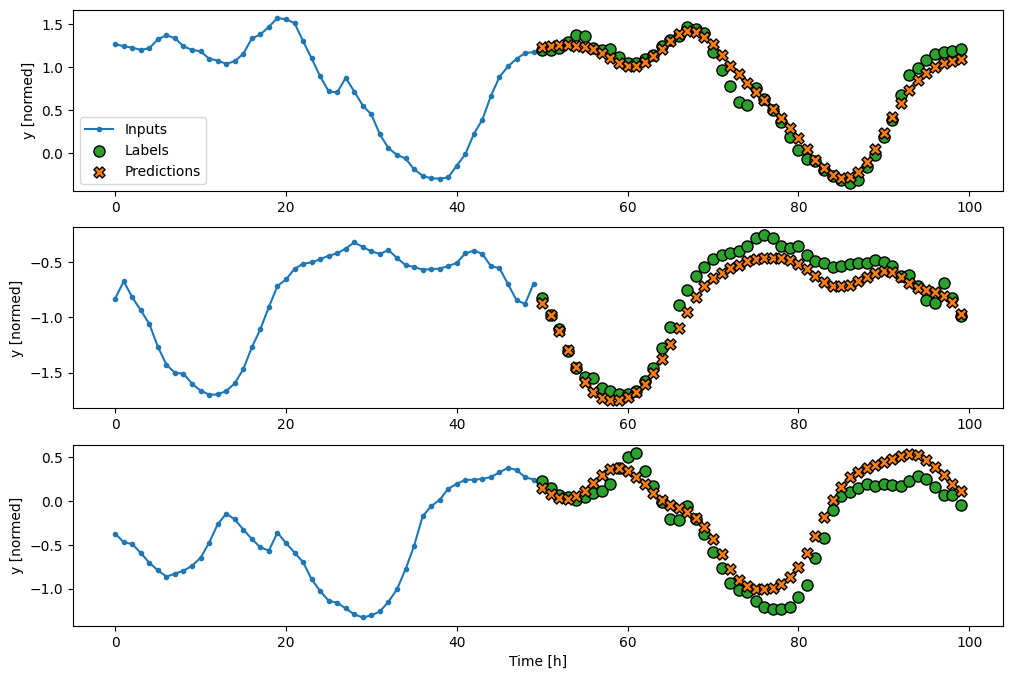

In [12]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = u.compile_and_fit(multi_lstm_model, multi_window)

val_performance['LSTM multi'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
performance['LSTM multi'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)


In [14]:
performance['LSTM multi']

{'loss': 0.04497253894805908, 'root_mean_squared_error': 0.21206724643707275}

In [23]:
#Saving model as h5 file so it can be loaded at anytime
multi_lstm_model.save("lstm_model_multi_step.h5")

Autoregressive model that takes its own predictions as inputs

In [21]:
feedback_model = u.FeedBack(units=32, out_steps=OUT_STEPS)

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

545/545 [==============================] - 6s 11ms/step - loss: 0.0685 - root_mean_squared_error: 0.2618


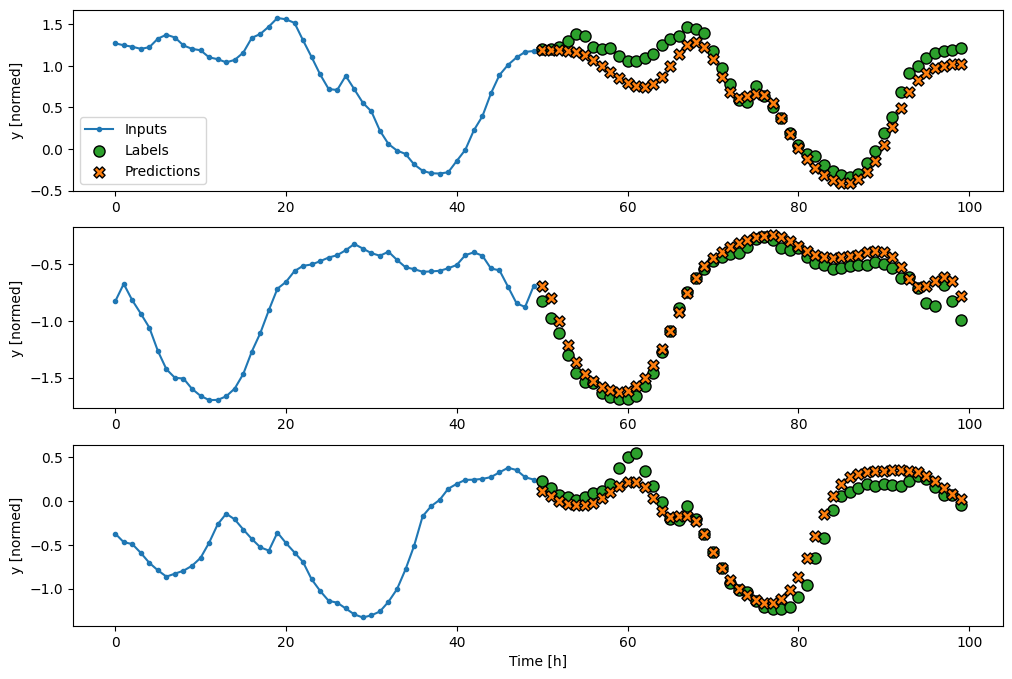

In [22]:
history = u.compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

In [30]:
single_lstm_model = keras.models.load_model("lstm_model_single_step.h5")
multi_lstm_model = keras.models.load_model("lstm_model_multi_step.h5")

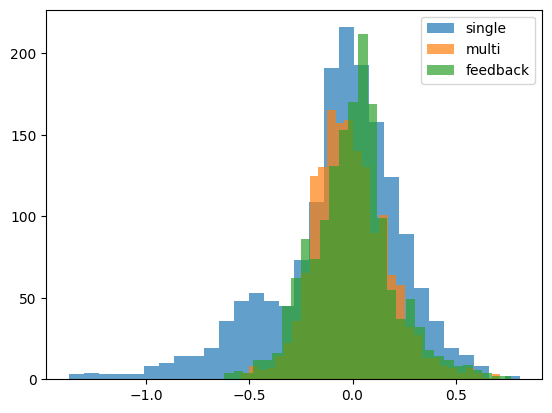

In [31]:
multi_window.compare_error_hist(models = [single_lstm_model,multi_lstm_model,feedback_model],label = ['single','multi','feedback'])